In [1]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [21]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [3]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

False


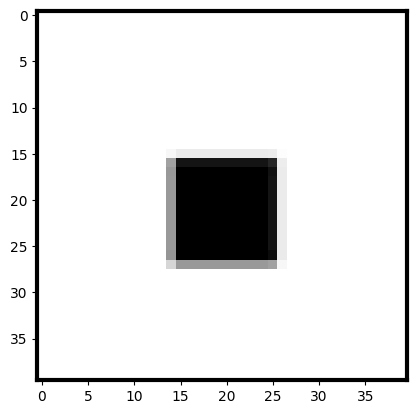

In [12]:
#will not work with mixed state probabilities
from PIL import Image
scale = 40
img = Image.open('images.png')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))

img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')

collapsed_array = np.zeros(img_array.size)

for i in range(0, img_array.size):
    collapsed_array[i] = img_array[int(i/scale)][i%scale]

test_data = np.zeros((int(img_array.size / 4), 4)) + 1j * np.zeros((int(img_array.size / 4), 4))
temp_normalize = max(collapsed_array) * 4
for i in range(0, int(img_array.size / 4)):
    test_data[i] = collapsed_array[4*i : 4*i+4] / temp_normalize + 1j * np.zeros(4)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

# Find where NaN values are
print(np.isnan(test_data).any())

# Get the indices of the NaN values
#nan_indices = np.where(img_array)

#print(nan_indices)

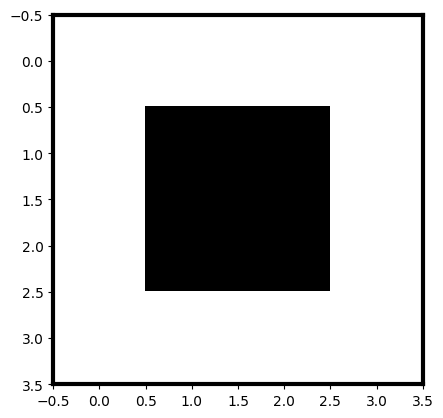

In [36]:
temp_test = np.array([[1, 1, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 1, 1]])
plt.imshow(temp_test, cmap='grey',interpolation = 'nearest')
temp_test = temp_test.flatten()


In [37]:
#generate diffusion data
n = 4
T = 20
Ndata = 1000

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(generate_training(temp_test, Ndata, 0.1))

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X
print(X)

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

np.save("states_diff", Xout)

(1000, 16)
(16,)
tensor([[0.2701+0.j, 0.2776+0.j, 0.3248+0.j,  ..., 0.2895+0.j, 0.2912+0.j, 0.3009+0.j],
        [0.2846+0.j, 0.2821+0.j, 0.3210+0.j,  ..., 0.3048+0.j, 0.2779+0.j, 0.2757+0.j],
        [0.2910+0.j, 0.2779+0.j, 0.2688+0.j,  ..., 0.2678+0.j, 0.3056+0.j, 0.2922+0.j],
        ...,
        [0.2973+0.j, 0.3035+0.j, 0.3041+0.j,  ..., 0.3033+0.j, 0.2689+0.j, 0.2689+0.j],
        [0.3079+0.j, 0.3045+0.j, 0.2768+0.j,  ..., 0.2978+0.j, 0.2737+0.j, 0.2758+0.j],
        [0.3009+0.j, 0.3065+0.j, 0.2787+0.j,  ..., 0.2672+0.j, 0.2780+0.j, 0.2775+0.j]],
       dtype=torch.complex128)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [38]:
from scipy.linalg import sqrtm

mixed_state = True

states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        #different calculations for mixed state fidelity
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2


fidelity_mean = np.mean(fidelity, axis = 1)
print(fidelity)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.97497464 0.9727524  0.96385532 ... 0.97056335 0.94027736 0.94879602]
 [0.89711004 0.89175775 0.92516778 ... 0.89764317 0.83621835 0.89763719]
 ...
 [0.02270218 0.10923811 0.01509338 ... 0.06786106 0.10082389 0.13004351]
 [0.01189768 0.09378377 0.01871268 ... 0.00880052 0.11893295 0.00330349]
 [0.02877678 0.24685049 0.03294124 ... 0.07033374 0.00248978 0.02977696]]


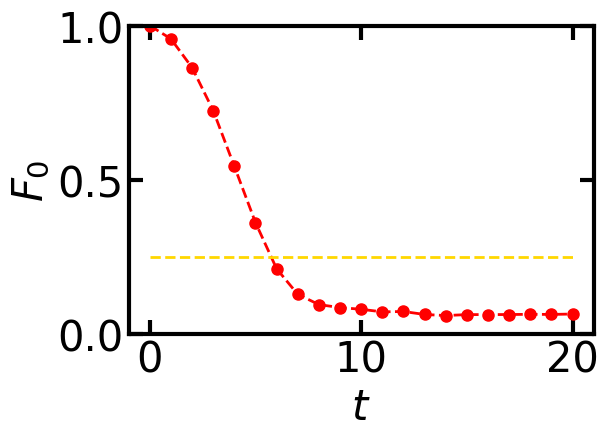

In [39]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 400
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)

ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [40]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [41]:
#train on diffusion data
n, na = 4, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 1000 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = np.load('states_diff.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('params_t%d.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('params_t%d'%t, params.detach().numpy())
    np.save('loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.0237, grad_fn=<SubBackward0>), time elapsed: 0.044426679611206055 seconds
Step 100, loss: tensor(0.0188, grad_fn=<SubBackward0>), time elapsed: 3.6468589305877686 seconds
Step 200, loss: tensor(0.0135, grad_fn=<SubBackward0>), time elapsed: 7.583684206008911 seconds
Step 300, loss: tensor(0.0095, grad_fn=<SubBackward0>), time elapsed: 11.234623193740845 seconds
Step 400, loss: tensor(0.0069, grad_fn=<SubBackward0>), time elapsed: 14.828076839447021 seconds
Step 500, loss: tensor(0.0055, grad_fn=<SubBackward0>), time elapsed: 18.605987548828125 seconds
Step 600, loss: tensor(0.0043, grad_fn=<SubBackward0>), time elapsed: 22.190311670303345 seconds
Step 700, loss: tensor(0.0037, grad_fn=<SubBackward0>), time elapsed: 25.95958399772644 seconds
Step 800, loss: tensor(0.0031, grad_fn=<SubBackward0>), time elapsed: 29.554603576660156 seconds
Step 900, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 33.12999963760376 seconds
Step 1000, loss: tensor(0.0023, g

In [42]:
n, na = 4, 1
T = 20
L = 6
Ndata = 1000
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('params_t%d.npy'%t)
    loss_tot[t] = np.load('loss_t%d.npy'%t)
    

np.save("params_total", params_tot)
np.save("loss_tot", loss_tot)                            

In [78]:
#Diffuse our test image
n = 4
T = 20
Ndata = 2

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(np.array([temp_test / (12**0.5) + 1j * np.zeros(2**n), temp_test / (12**0.5) + 1j * np.zeros(2**n)]))

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X
print(X)

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

tensor([[0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.0000+0.j, 0.0000+0.j,
         0.2887+0.j, 0.2887+0.j, 0.0000+0.j, 0.0000+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j,
         0.2887+0.j, 0.2887+0.j],
        [0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j, 0.0000+0.j, 0.0000+0.j,
         0.2887+0.j, 0.2887+0.j, 0.0000+0.j, 0.0000+0.j, 0.2887+0.j, 0.2887+0.j, 0.2887+0.j,
         0.2887+0.j, 0.2887+0.j]], dtype=torch.complex128)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [80]:
#use model to predict what original image was from diffused image
test_data_T20 = torch.tensor(Xout[20], dtype = torch.complex64)

n, na = 4, 1
T = 20
L = 6
Ndata = 2

diffModel = DiffusionModel(n, T, Ndata)

params_tot = np.load('params_total.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_te = model.backDataGeneration(test_data_T20, params_tot, Ndata)[:, :, :2**n].numpy()

np.save("test_backwardsgen", data_te)

In [81]:
backwards_gen = np.load('test_backwardsgen.npy')
print(backwards_gen[0])

[[-0.15816104-0.13904741j -0.25737414-0.13940307j -0.28428164-0.17128439j
  -0.23532577-0.126599j   -0.36317697+0.02347497j -0.06081451-0.11030737j
  -0.07182556+0.01043527j -0.09169445-0.09704224j -0.29749438-0.04560809j
  -0.01526539+0.05411374j  0.11243391+0.00599276j -0.28224304-0.081847j
  -0.18680702-0.00414534j -0.25141487-0.08464026j -0.13183317-0.22414818j
  -0.32935873-0.20697829j]
 [ 0.09230567-0.02622197j  0.2522527 -0.15812525j  0.3123673 -0.25188184j
   0.22630785-0.17329903j  0.25219518-0.02641458j  0.1489203 -0.13261245j
   0.36864215-0.04288882j  0.17342223+0.13459219j -0.01362134+0.00786014j
   0.15730499-0.0076059j   0.07797672-0.24134773j  0.2566847 -0.03932514j
   0.24636595-0.16947624j  0.05729499-0.16859303j  0.29036883+0.051177j
   0.06954581+0.01393153j]]


In [88]:
backwards_gen = np.load('test_backwardsgen.npy')
dim = 4#int((final_output_flattened.size) ** 0.5)
final_output_nxn = np.zeros((T + 1, dim, dim))

for z in range(0, 21):
    final_output_flattened = backwards_gen[z]
    final_output_flattened = np.abs(final_output_flattened)
    multiplier = np.max(final_output_flattened)
    final_output_flattened /= multiplier
    final_output_flattened = final_output_flattened.flatten()

    for i in range(0, dim):
        for j in range(0, dim):
            final_output_nxn[z][i][j] = final_output_flattened[(i*dim) + j]



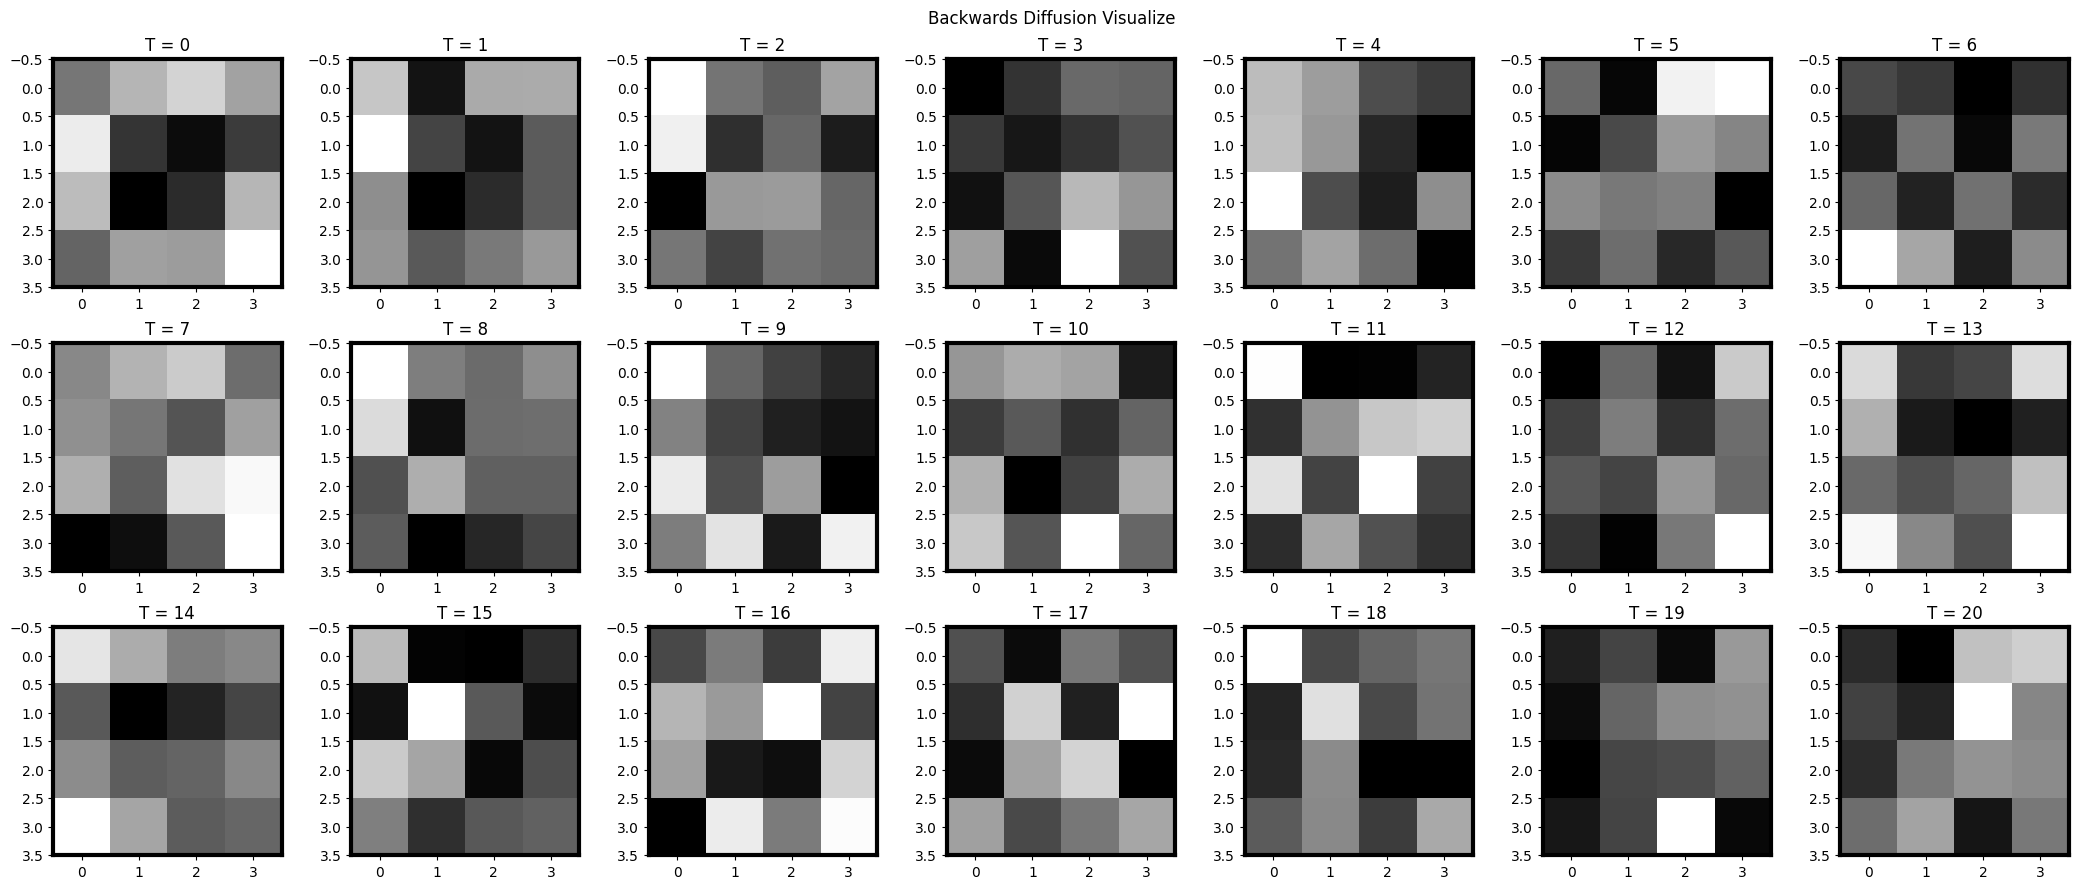

In [89]:
fig, axs = plt.subplots(3, 7, figsize = (21, 9))

for z in range(0, 21):
    #print(final_output_nxn[z])
    axs[int(z/7)][z%7].imshow(final_output_nxn[z], cmap = 'grey', interpolation = 'nearest')
    axs[int(z/7)][z%7].set_title('T = %d'%z)

plt.suptitle('Backwards Diffusion Visualize')
plt.tight_layout()
plt.show()